# Tutorial: Products of Adjacency Matrices

## One. Static networks

In [1]:
%matplotlib inline

import scipy.sparse as sp
import networkx as nx

import matplotlib.pyplot as plt

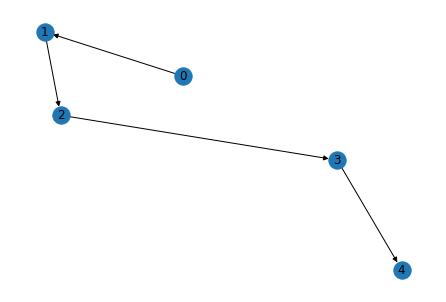

In [2]:
G = nx.empty_graph(5, create_using=nx.DiGraph)
G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 4)

nx.draw(G, with_labels=True)
plt.show()

In [3]:
A = nx.to_scipy_sparse_matrix(G)
#print(A)
print(A**2)

  (0, 2)	1
  (1, 3)	1
  (2, 4)	1


In [4]:
P = A + A**2 + A**3 + A**4

n = 1
Pn = A
print(n, Pn.nnz)

for n in range(2, 4):
    Pn += A**n
    print(n, Pn.nnz)

1 4
2 7
3 9


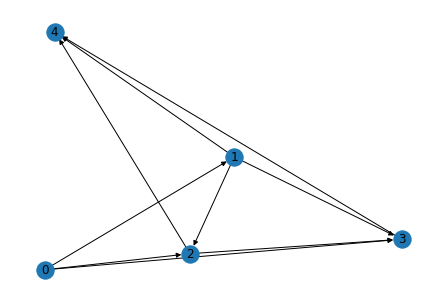

In [5]:
P_graph = nx.from_scipy_sparse_matrix(Pn, create_using=nx.DiGraph)
nx.draw(P_graph, with_labels=True)
plt.show()

## Two. Temporal networks

In [6]:
# Empty snapshots
G1 = nx.empty_graph(5)
G2 = nx.empty_graph(5)
G3 = nx.empty_graph(5)
G4 = nx.empty_graph(5)

# edges
G1.add_edge(1, 2)
G1.add_edge(0, 3)

G2.add_edge(1, 4)

G3.add_edge(0, 4)
G3.add_edge(0, 1)

G1.add_edge(1, 2)

In [7]:
A1 = nx.to_scipy_sparse_matrix(G1)
I = sp.identity(5)
Pn = A1 + I

for snapshot in (G2, G3, G4):
    At = nx.to_scipy_sparse_matrix(snapshot)
    Pn *= At + I 
    
print(Pn)
# NOTE: (3, 1) is unidirectional

  (0, 3)	1.0
  (0, 0)	1.0
  (0, 1)	1.0
  (0, 4)	1.0
  (1, 2)	1.0
  (1, 0)	2.0
  (1, 4)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (2, 0)	2.0
  (2, 4)	1.0
  (2, 1)	1.0
  (3, 3)	1.0
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 4)	1.0
  (4, 0)	2.0
  (4, 4)	1.0
  (4, 1)	1.0


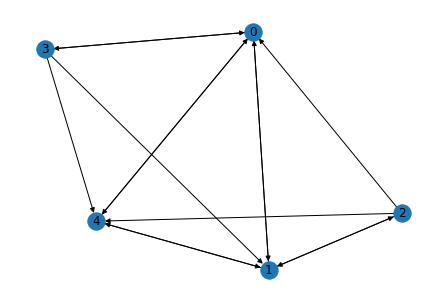

In [8]:
P_graph = nx.from_scipy_sparse_matrix(Pn, create_using=nx.DiGraph)
nx.draw(P_graph, with_labels=True)
plt.show()

# Tutorial: AdjMatrixSequence Class

In [9]:
import sys
import numpy as np
sys.path.append('./src')
from AdjacencyMatrixSequence import AdjMatrixSequence
# from TemporalNetworkEdgeList import TemporalEdgeList
# import Tools

## Read some data
And generate an AdjMatrixSequence Object

In [10]:
#the_file = 'edgelists/Test.dat'
the_file = "edgelists/sociopatterns_hypertext.dat"
#the_file = "edgelists/Trade.txt"
At = AdjMatrixSequence(the_file, directed=True, write_label_file=False)

## Compute Accessibility and its derivative

In [11]:
# compute accessibility
c = At.unfold_accessibility(return_accessibility_matrix=False, verbose=False)

# derivative of accessibility profile
h = np.gradient(c)


---> Unfolding complete.


## Plot the results

/Users/lentz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """
/Users/lentz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


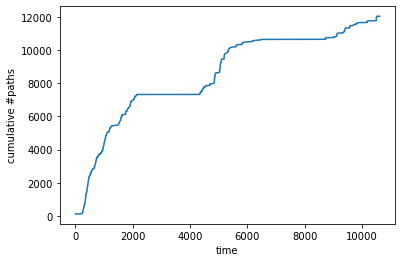

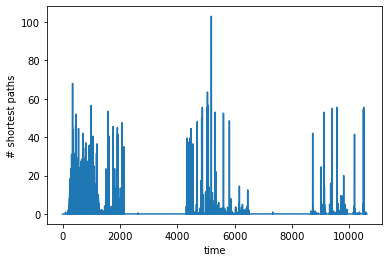

In [12]:
f = plt.figure(1)
plt.xlabel("time")
plt.ylabel("cumulative #paths")
plt.plot(c)
f.show()

g = plt.figure(2)
plt.xlabel("time")
plt.ylabel("# shortest paths")
plt.plot(h)
g.show()

## Compute causal fidelity

In [13]:
# Causal fidelity
causal_paths = c[-1]
static_paths = At.static_path_density()
print("---> Causal fidelity is ", float(causal_paths)/float(static_paths))

---> Causal fidelity is  0.9695239626889676


### Compute Causal Fidelity for an increasing aggregation window

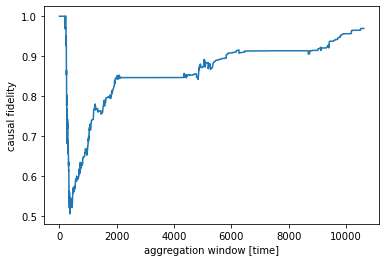

In [14]:
# path density of the static network for different aggregation windows
# Warning: this might be slow. In doubt set verbose=True to see the progress.
c2 = At.step_by_step_static_path_density(verbose=False)

# causal fidelity is number of causal paths divided by number of static paths
c_ff = [c[i]/c2[i] for i in range(len(c))]

# plot the result
plt.xlabel("aggregation window [time]")
plt.ylabel("causal fidelity")
plt.plot(c_ff) # plotting t, c separately 
plt.show()

Considering the network as static starts to make sense after about 2000 time steps. The high causal fidelity at the beginning is a trvial effect: the network is very sparse and most paths are short (length 1), so causality does not play a role yet.

## Tracing forward and backward
This is just single node accessibility unfolding. We use pandas here for plotting, and matplotlib works, too.

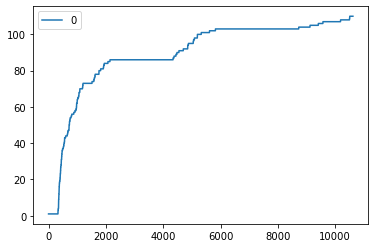

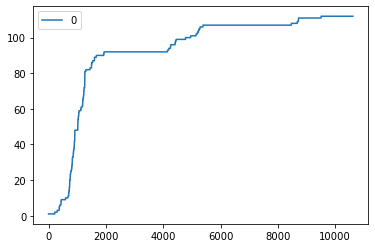

In [15]:
import pandas as pd
# tracing forward
node_name = 101

c1 = At.unfold_accessibility_single_node(node_name)
c1df = pd.DataFrame(c1)
c1df.plot()

# tracing backward
Bt = At.copy()
Bt.time_reversed()
c2 = Bt.unfold_accessibility_single_node(node_name)
c2df = pd.DataFrame(c2)
c2df.plot()

if you want to have the nodes reachable from the starting node, use ```At.trace_forward(node_name)```. Note that the resulting dictionary can be huge.

In [25]:
node_name = 101
reachable_nodes = At.trace_forward(node_name, stop=1000)
print("The reachable nodes of node " + str(node_name) + " after 500 time steps are:\n",reachable_nodes[500])

The reachable nodes of node 101 after 500 time steps are:
 {13, 25, 29, 32, 34, 35, 38, 39, 40, 45, 51, 52, 53, 56, 57, 58, 60, 61, 62, 64, 81, 86, 87, 88, 94, 99, 100, 101, 102, 104, 105, 107, 108, 109, 110, 111, 112}
